<a href="https://colab.research.google.com/github/sedagulerr/NLP-ile-Tarot-Karti-Okuma/blob/main/TAROT_KARTI_OKUMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Doğal dil işleme (NLP) modeli kullanılarak kullanıcı girdilerine göre tarot kartları öneriliyor ve kartların anlamları kullanıcıya sunuluyor.

# NLP Modeli Kullanımı: Kodu yazarken SentenceTransformer modeli kullanılıyor. Bu model, metin tabanlı benzerlik hesaplamaları için kullanılıyor.

# Kullanıcı Girdilerinin İşlenmesi: Kullanıcının girdiği metin analiz edilerek niyet belirleniyor ve uygun tarot kartı seçiliyor.

# Görsellerin Gösterimi: Kartların görselleri yüklenip gösteriliyor.

# Konsol Renkleri: Konsolda renkli ve stilize edilmiş çıktılar oluşturmak için ANSI kaçış dizileri kullanılıyor.

# Soru-Cevap ve Tavsiye Mekanizması: Kullanıcı girdilerine göre önerilerde bulunan ve kullanıcıya ikinci bir kart önerisi sunan bir yapı oluşturuluyor.

In [2]:
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import json
import seaborn
import pandas as pd
import os
import cv2
import spacy
import ipywidgets as widgets
from IPython.display import display, clear_output
from pandas import json_normalize
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import SentenceTransformer
from scipy.ndimage import rotate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

In [3]:
# JSON dosyasından tarot kartlarını okuma
data_dir = '/content/'  # Görsellerin ve JSON'un olduğu dizin
df = pd.read_json(data_dir + 'tarot-images.json', orient='records')
df_cards = pd.json_normalize(df['cards'])
df_cards

,name,number,arcana,suit,img,fortune_telling,keywords,Archetype,Hebrew Alphabet,Numerology,Elemental,Mythical/Spiritual,Questions to Ask,meanings.light,meanings.shadow,Astrology,Affirmation
0,The Fool,0,Major Arcana,Trump,m00.jpg,"[Watch for new projects and new beginnings, Pr...","[freedom, faith, inexperience, innocence]",The Divine Madman,Aleph/Ox/1,0 (off the scale; pure potential),Air,Adam before the fall. Christ as a wandering ho...,[What would I do if I felt free to take a leap...,"[Freeing yourself from limitation, Expressing ...","[Being gullible and naive, Taking unnecessary ...",NaN,NaN
1,The Magician,1,Major Arcana,Trump,m01.jpg,"[A powerful man may play a role in your day, Y...","[capability, empowerment, activity]",The Ego/The Self,Beth/House/2,"1 (origins, unity, seeds)",The Sun/Mercury,"Thoth, the Egyptian god of wisdom, known to th...","[What am I empowered to do?, How might my abil...","[Taking appropriate action, Receiving guidance...","[Inflating your own ego, Abusing talents, Mani...",NaN,NaN
2,The High Priestess,2,Major Arcana,Trump,m02.jpg,"[A mysterious woman arrives, A sexual secret m...","[intuition, reflection, purity, initiation]",The Virgin/The Maiden,Gimel/Camel/3,"2 (division, debate, duality)",The Moon,"The feminine aspect of divinity, particularity...","[What might a rebel against tradition do?, Wha...","[Listening to your feelings and intuitions, Ex...","[Being aloof, Obsessing on secrets and conspir...",NaN,NaN
3,The Empress,3,Major Arcana,Trump,m03.jpg,"[Pregnancy is in the cards, An opportunity to ...","[fertility, productivity, ripeness, nurturing]",The Mother,Daleth/Door/4,"3 (expression, productivity, output)",Venus,"Gaia, Mother Earth, Ishtar, DemeterÑmature, re...",[What would a concerned and capable mother do?...,"[Nurturing yourself and others, Bearing fruit,...","[Overindulging, Being greedy, Smothering someo...",NaN,NaN
4,The Emperor,4,Major Arcana,Trump,m04.jpg,"[A father figure arrives, A new employer or au...","[authority, regulation, direction, structure]",The Father,"He[as]/Window/5, or in some decks, Tzaddi/Fish...","4 (stability, equality, persistence)",Mars/Aries,"Masculine gods, including the Hebrew God, the ...",[How does the issue of control or regulation i...,"[Exercising authority, Defining limits, Direct...","[Micromanaging, Crushing the creativity of oth...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Ten of Pentacles,10,Minor Arcana,Pentacles,p10.jpg,"[Big money is in the near future, Expect a pow...","[wealth, abundance, acquisition, greed]",NaN,NaN,"10 (The End: finality, completion, exhaustion)",NaN,NaN,"[How much stuff do I really need?, How do I fe...",[Celebrating your physical and financial bless...,[Spending all of your money on extravagant gif...,Mercury in Virgo,"""I keep physical and financial matters in pers..."
74,Page of Pentacles,11,Minor Arcana,Pentacles,p11.jpg,[This card represents a young man or woman wit...,"[practicality, prosperity, learning, growth, a...",NaN,NaN,NaN,Earth of Earth.,NaN,[How can you get more financial or sexual expe...,"[Learning the value of a dollar, Starting a sa...",[Trying to appear healthier or wealthier than ...,NaN,"""I am physically and financially responsible."""
75,Knight of Pentacles,12,Minor Arcana,Pentacles,p12.jpg,[A stingy person may chide you for spending mo...,"[caution, focus, realism, invention]",NaN,NaN,NaN,Air of Earth.,NaN,[What's the difference between caution and fea...,"[Spending money wisely, Saving for a rainy day...","[Throwing caution to the four winds, Spending ...",NaN,"""I temper my actions with cautious optimism."""
76,Queen of Pentacles,13,Minor Arcana,Pentacles,p13.jpg,[This card represents a woman with an expansiv...,"[luxury, comfort, resourcefulness, generosity,...",NaN,NaN,NaN,Water of Earth.,NaN,"[How do I define luxury?, To what extent am I ...","[Appreciating fine food, fine wine, beautiful ...","[Indulging in gluttony or greediness, Becoming..."

In [4]:
# Konsol renkleri
class ConsoleColors:
    RESET = "\033[0m"
    BOLD = "\033[1m"
    CYAN = "\033[96m"
    RED = "\033[91m"
    YELLOW = "\033[93m"
    GREEN = "\033[92m"
    BLUE = "\033[94m"
    ORANGE = "\033[38;5;214m"

In [5]:
# Bugünün nasıl geçecek görmek ister misin?

Bugünün nasıl geçecek görmek ister misin? (evet/hayır): evet

Sizin için seçilen kart: Six of Cups
Anlamı (Light): ['Donating your time and talents to others', 'Taking satisfaction in knowing how your efforts will aid others', 'Creating a "win-win" scenario', 'Giving even when you know repayment is not possible', 'Being motivated to do a good deed']
Anlamı (Shadow): ['Linking your sense of self-worth to the appraisals of others', 'Striving to appear more needy than you really are', 'Taking undeserved or unmerited charity', 'Bragging about your charitable efforts', 'Profiteering in times of distress', 'Refusing to share a burden']
Kartın genel yorumu: Olumsuz ⚡


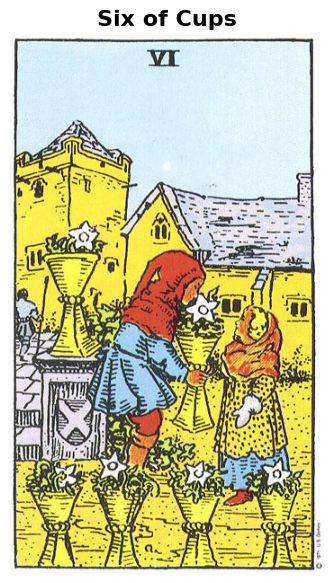

In [7]:
# JSON dosyasından tarot kartlarını okuma
df_cards = pd.json_normalize(df['cards'])

# Kullanıcıya sorma
response = input("Bugünün nasıl geçecek görmek ister misin? (evet/hayır): ").strip().lower()

if response in ["evet", "yes"]:
    # Rastgele bir kart seçme
    random_card_idx = random.randint(0, len(df_cards) - 1)
    random_card = df_cards.iloc[random_card_idx]

    # Light ve Shadow anlamlarını karşılaştırma
    light_meanings = random_card['meanings.light']
    shadow_meanings = random_card['meanings.shadow']
    light_count = len(light_meanings)
    shadow_count = len(shadow_meanings)

    # Light ve Shadow'a göre mesaj belirleme
    if light_count > shadow_count:
        dominance_message = f"{ConsoleColors.GREEN}Kartın genel yorumu: Olumlu 🌟{ConsoleColors.RESET}"
    elif shadow_count > light_count:
        dominance_message = f"{ConsoleColors.RED}Kartın genel yorumu: Olumsuz ⚡{ConsoleColors.RESET}"
    else:
        dominance_message = f"{ConsoleColors.BLUE}Kartın genel yorumu: Dengeli ⚖{ConsoleColors.RESET}"

    # Kart bilgilerini yazdırma
    print(f"\nSizin için seçilen kart: {random_card['name']}")
    print(f"Anlamı (Light): {light_meanings}")
    print(f"Anlamı (Shadow): {shadow_meanings}")
    print(dominance_message)

    # Kart görselini gösterme
    image_path = os.path.join(data_dir, random_card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(random_card['name'], fontsize=16, fontweight='bold')
        plt.show()
    else:
        print(f"{ConsoleColors.RED}Görsel bulunamadı: {image_path}{ConsoleColors.RESET}")
else:
    print(f"{ConsoleColors.BLUE}Tamam, bir dahaki sefere görüşürüz!{ConsoleColors.RESET}")

In [8]:
# Ne hisettigini yazinca bir kart onerme (ing olan)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Bir soru sorun ya da ne hissettiğinizi yazın: How will my career progress?

Sizin için seçilen kart: Seven of Pentacles
Anlamı (Light): ['Measuring progress toward your goal', 'Looking at results with an eye toward improving performance', 'Asking, "How happy am I?"', 'Coming up with ideas for improving your health or prosperity', "Deciding it's time for a change", 'Expressing an honest opinion']
Anlamı (Shadow): ['Becoming distracted by melancholy thoughts', 'Longing for "the good old days"', 'Beating yourself up over lost opportunities', 'Judging your own work harshly', 'Holding others to inappropriate standards', 'Refusing to take part in a project, then whining about the quality of the outcome']
Kartın genel yorumu: Dengeli ⚖


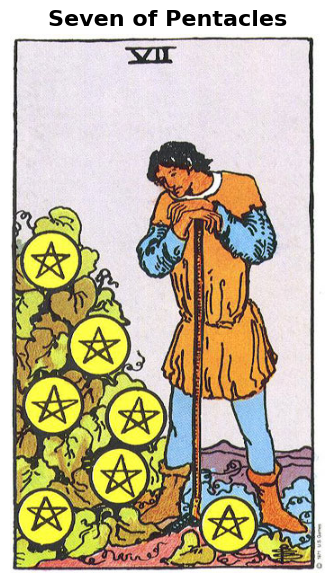

In [9]:
# Modeli yükleme
model = SentenceTransformer('all-MiniLM-L6-v2')

# JSON dosyasından tarot kartlarını okuma
df_cards = pd.json_normalize(df['cards'])

# Kart açıklamalarını hazırlama
card_descriptions = df_cards['meanings.light'].fillna('').tolist()
card_embeddings = model.encode(card_descriptions)

# Kullanıcı girdisi
user_input = input("Bir soru sorun ya da ne hissettiğinizi yazın: ") #Kullanıcı Girdisinin Analiz Edilmesi.
user_embedding = model.encode(user_input)

# Benzerlik hesaplama
# kart açıklamaları ile kullanıcının girdisinin benzerliği hesaplanıyor ve en yüksek
scores = util.cos_sim(user_embedding, card_embeddings)[0]
best_card_idx = scores.argmax().item()  # Tamsayıya dönüştürme

# En iyi eşleşmeyi yazdırma
best_card = df_cards.iloc[best_card_idx]

# Light ve Shadow anlamlarını kontrol etme
light_meanings = best_card['meanings.light']
shadow_meanings = best_card['meanings.shadow']
light_count = len(light_meanings)
shadow_count = len(shadow_meanings)

# Light ve Shadow'a göre mesaj belirleme
if light_count > shadow_count:
    dominance_message = f"{ConsoleColors.GREEN}Kartın genel yorumu: Olumlu 🌟{ConsoleColors.RESET}"
elif shadow_count > light_count:
    dominance_message = f"{ConsoleColors.RED}Kartın genel yorumu: Olumsuz ⚡{ConsoleColors.RESET}"
else:
    dominance_message = f"{ConsoleColors.BLUE}Kartın genel yorumu: Dengeli ⚖{ConsoleColors.RESET}"

# Kart bilgilerini yazdırma
print(f"\nSizin için seçilen kart: {best_card['name']}")
print(f"Anlamı (Light): {light_meanings}")
print(f"Anlamı (Shadow): {shadow_meanings}")
print(dominance_message)

# Kart görselini gösterme
image_path = os.path.join(data_dir, best_card['img'])
if os.path.exists(image_path):
    img = plt.imread(image_path)
    plt.figure(figsize=(5, 7))
    plt.imshow(img)
    plt.axis('off')
    plt.title(best_card['name'], fontsize=16, fontweight='bold')
    plt.show()
else:
    print(f"Görsel bulunamadı: {image_path}")


 # soru örnekleri   How will my career progress?    I'm feeling so stressed, what can I do?    What will my friendships be like?

In [10]:

# Kullanıcı Girdisi ve Kart Seçimi:
#Birinci Kod:
#Kullanıcı tarafından girilen bir soru veya his, metin benzerlik hesaplamaları kullanılarak kartlarla eşleştirilir.
#Kullanıcının girdisi, her bir kart açıklamasıyla karşılaştırılır ve en yüksek benzerliğe sahip kart seçilir.

#İkinci Kod:
#Kullanıcı girdisi, önce bazı anahtar kelimelerle kategorilere (suit) ayrılır (örneğin aşk, iş, sağlık vb.).
#Bu kategorilere dayalı olarak kartlar filtrelenir ve en uygun kart rastgele seçilir.


#2. Kategorik Seçim:
#Birinci Kod:
#Kartlar, kullanıcının sorusu ile doğrudan metin benzerliği yoluyla seçilir. Kart açıklamalarının içerikleriyle hesaplama yapılarak en iyi eşleşme bulunur.

#İkinci Kod:
#Öncelikle girdiye göre bir kategori belirlenir (aşk, kariyer, sağlık vb.).
# Kullanıcının sorusundaki anahtar kelimelere göre "Pentacles", "Cups", "Wands" gibi suitlerden biri seçilir ve bu suit ile ilişkili kartlar arasında bir seçim yapılır.


#Birinci Kod: Kart açıklamalarına dayalı metin benzerliği ile eşleşen kartı bulur. Daha basit ve temel bir yapı sunar.
#İkinci Kod: Girdiyle ilişkili bir suit seçerek daha kategorik bir yaklaşımla kart önerisi yapar.

In [11]:
# Niyet Analizi

In [13]:

# NLP modeli yükle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tarot kartlarını yükle
data_dir = '/content/'  # Görsellerin olduğu klasör yolu
json_path = '/content/tarot-images.json'
df = pd.read_json(json_path, orient='records')
df_cards = pd.json_normalize(df['cards'])

# Suit açıklamaları
suit_explanations = {
    "Wands": "Ateş elementinin serisidir. Aslan, Koç, Yay burçlarını temsil eder. Bu kartlar hareketliliğe, hıza ve yaratıcılığa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. Yengeç, Akrep, Balık burçlarını temsil eder. Bu kartlar duygulara, alışkanlıklara ve bilinçaltına dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. İkizler, Kova, Terazi burçlarını temsil eder. Bu kartlar düşüncelere, inançlara ve zihinsel mücadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. Boğa, Başak, Oğlak burçlarını temsil eder. Bu kartlar dünya işleri, doğa ve fiziksel yapıya dair bilgileri verir.",
    "Major Arcana": "Büyük Arkana kartları yaşamın önemli temalarını ve dönüşümlerini temsil eder. Her biri farklı bir ders sunar."
}

# Kart görselini gösterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}Görsel bulunamadı: {image_path}{ConsoleColors.RESET}")

# Light ve Shadow baskınlığına göre mesaj ekleme
def determine_dominance(light_meanings, shadow_meanings):
    light_count = len(light_meanings)
    shadow_count = len(shadow_meanings)

    if light_count > shadow_count:
        return f"{ConsoleColors.GREEN}Kartın genel yorumu: Olumlu 🌟{ConsoleColors.RESET}"
    elif shadow_count > light_count:
        return f"{ConsoleColors.RED}Kartın genel yorumu: Olumsuz ⚡{ConsoleColors.RESET}"
    else:
        return f"{ConsoleColors.BLUE}Kartın genel yorumu: Dengeli ⚖{ConsoleColors.RESET}"

# Niyet ve girişlere göre kart önerme
def recommend_card_by_intent(user_input):
    intent = "Genel"
    suit_selection = None

    if any(word in user_input for word in ["aşk", "ilişki", "sevgi", "arkadaş", "duygu", "romantizm"]):
        suit_selection = "Cups"
        intent = "Aşk ve İlişkiler"
    elif any(word in user_input for word in ["iş", "kariyer", "para", "zenginlik", "başarı", "maddi"]):
        suit_selection = "Pentacles"
        intent = "Kariyer ve Maddiyat"
    elif any(word in user_input for word in ["sağlık", "şifa", "hastalık", "iyileşme", "beden", "ruh"]):
        suit_selection = "Major Arcana"
        intent = "Sağlık ve Şifa"
    elif any(word in user_input for word in ["düşünce", "zihin", "mantık", "karar", "analiz", "fikri"]):
        suit_selection = "Swords"
        intent = "Zihin ve Karar"
    elif any(word in user_input for word in ["yaratıcı", "enerji", "hareket", "tutku", "hedef"]):
        suit_selection = "Wands"
        intent = "Yaratıcılık ve Hareket"

    # Seçilen suit'e göre kart filtreleme
    filtered_cards = df_cards[df_cards['suit'].str.contains(suit_selection, case=False, na=False)] if suit_selection else df_cards
    selected_card = filtered_cards.sample(1).iloc[0]

    # Kart bilgilerini yazdırma
    print(f"{ConsoleColors.ORANGE}{intent} kategorisinde sizin için bir kart seçtim!{ConsoleColors.RESET}")
    print(f"{ConsoleColors.BOLD}Kart İsmi:{ConsoleColors.RESET} {selected_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {selected_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {selected_card['meanings.shadow']}")

    # Suit açıklaması ekleme
    suit_description = suit_explanations.get(suit_selection, "Genel bir kategori açıklaması mevcut değil.")
    print(f"{ConsoleColors.BOLD}Suit Açıklaması:{ConsoleColors.RESET} {suit_description}")

    # Light ve Shadow anlamlarını değerlendir
    dominance_message = determine_dominance(selected_card['meanings.light'], selected_card['meanings.shadow'])
    print(dominance_message)

    display_card_image(selected_card)

    return selected_card


# İkinci kart önerme
def recommend_related_card(first_card):
    print(f"\n{ConsoleColors.YELLOW}İlk kartınıza göre ikinci kart öneriliyor...{ConsoleColors.RESET}")

    # İlk kartın light anlamını al
    first_card_meaning = first_card['meanings.light']

    # Diğer kartları filtrele (ilk kart hariç)
    other_cards = df_cards[df_cards['name'] != first_card['name']]

    # Tüm kartların light anlamlarını al ve benzerlik skoru hesapla
    card_meanings = other_cards['meanings.light'].tolist()
    embeddings = model.encode([first_card_meaning] + card_meanings)
    similarity_scores = util.cos_sim([embeddings[0]], embeddings[1:])

    # En yüksek benzerlik skoruna sahip olan kartı seç
    best_match_index = similarity_scores.numpy().argmax()  # NumPy yöntemi ile argmax işlemi
    second_card = other_cards.iloc[best_match_index]

    # İkinci kart bilgilerini yazdır
    print(f"{ConsoleColors.BOLD}İkinci Kart:{ConsoleColors.RESET} {second_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {second_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {second_card['meanings.shadow']}")

    # Suit açıklaması ekle
    suit_description = suit_explanations.get(second_card['suit'], "Genel bir kategori açıklaması mevcut değil.")
    print(f"{ConsoleColors.BOLD}Suit Açıklaması:{ConsoleColors.RESET} {suit_description}")

    # Görseli göster
    display_card_image(second_card)

# Tarot kart önerme uygulaması

def main():
    output = widgets.Output()
    display(output)

    while True:
        with output:
            clear_output(wait=True)
            user_input = input("\nBir soru sorun ya da ne hissettiğinizi yazın (Çıkmak için 'çıkış'): ").strip()

            if user_input.lower() in ["çıkış", "exit", "quit"]:
                print(f"{ConsoleColors.ORANGE}Görüşmek üzere, tekrar bekleriz! 🌟{ConsoleColors.RESET}")
                break

            # İlk kartı seç
            first_card = recommend_card_by_intent(user_input)

            while True:
                cont = input(f"\nİlk karta göre ikinci bir kart seçmek ister misiniz? (evet/hayır): ").strip().lower()
                if cont in ["evet", "yes"]:
                    recommend_related_card(first_card)
                    break  # İkinci kart seçildi, döngüden çık
                elif cont in ["hayır", "no"]:
                    print(f"{ConsoleColors.ORANGE}Harika bir gün geçirmenizi dilerim! 🌟{ConsoleColors.RESET}")
                    break  # Döngüden çık
                else:
                    print(f"{ConsoleColors.RED}Lütfen 'evet' veya 'hayır' yazın.{ConsoleColors.RESET}")

            # Kullanıcı "evet" veya "hayır" dedikten sonra dış döngüye dön
            if cont in ["hayır", "no"]:
                break  # Kullanıcı istemiyorsa tamamen çık

# Programı başlat
if __name__ == "__main__":
    main()

Output()


Bir soru sorun ya da ne hissettiğinizi yazın (Çıkmak için 'çıkış'): kariyerim nasıl ilerleyecek

İlk karta göre ikinci bir kart seçmek ister misiniz? (evet/hayır): evet

Bir soru sorun ya da ne hissettiğinizi yazın (Çıkmak için 'çıkış'): çıkış


In [14]:
# EVET-HAYIR sorusu sorma

Bir soru sorun ya da ne hissettiğinizi yazın (Çıkmak için 'çıkış'): 
>>> iyi bir işim olacak mı

Sizin için bir kart çektim!
Kart İsmi: Queen of Wands
Light Anlam: ['Paying close attention', 'Helping others focus on the issue at hand', 'Getting everyone to work together', 'Identifying common ground', 'Bringing people together, despite their differences', 'Using reverse psychology']
Shadow Anlam: ['Being distracted, or using your charms or skills to distract others from the goal', 'Calling attention to yourself with negative or unhealthy behaviors', 'Disrupting group activities as a means of feeding your own ego']
Çekiliş Tarihi: 2025-07-28 20:11:45

Suit Açıklaması: Ateş elementinin serisidir. Aslan, Koç, Yay burçlarını temsil eder. Bu kartlar hareketliliğe, hıza ve yaratıcılığa dair bilgileri bize sunar.


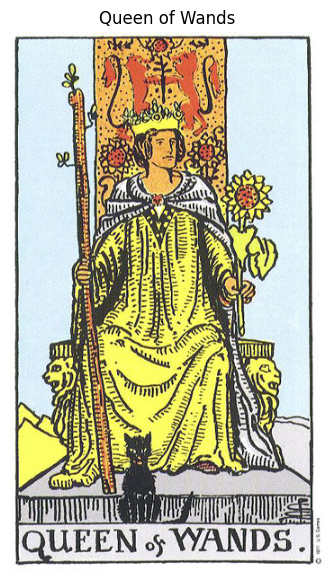


Cevap: Hayır
Light Skor: 0.06
Shadow Skor: 0.08

Harika bir gün geçirmenizi dilerim! 🌟


In [16]:

# NLP modeli yükle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Suit açıklamaları
suit_explanations = {
    "Wands": "Ateş elementinin serisidir. Aslan, Koç, Yay burçlarını temsil eder. Bu kartlar hareketliliğe, hıza ve yaratıcılığa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. Yengeç, Akrep, Balık burçlarını temsil eder. Bu kartlar duygulara, alışkanlıklara ve bilinçaltına dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. İkizler, Kova, Terazi burçlarını temsil eder. Bu kartlar düşüncelere, inançlara ve zihinsel mücadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. Boğa, Başak, Oğlak burçlarını temsil eder. Bu kartlar dünya işleri, doğa ve fiziksel yapıya dair bilgileri verir.",
    "Major Arcana": "Büyük Arkana kartları yaşamın önemli temalarını ve dönüşümlerini temsil eder. Her biri farklı bir ders sunar."
}

# Kart görselini gösterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}Görsel bulunamadı: {image_path}{ConsoleColors.RESET}")

# Cevap değerlendirme fonksiyonu
def evaluate_card(card, user_input):
    # Kullanıcının sorusunu vektörleştir
    user_embedding = model.encode(user_input)

    # Kartın "light" ve "shadow" anlamları
    light_meaning = card['meanings.light']
    shadow_meaning = card['meanings.shadow']

    # Vektörleştirme ve benzerlik hesaplama
    light_embedding = model.encode(light_meaning)
    shadow_embedding = model.encode(shadow_meaning)

    light_score = util.cos_sim(user_embedding, light_embedding).mean().item()
    shadow_score = util.cos_sim(user_embedding, shadow_embedding).mean().item()

    # Evet veya Hayır cevabını belirleme
    response = "Evet" if light_score > shadow_score else "Hayır"

    # Sonuçları döndür
    return {
        "response": response,
        "light_score": light_score,
        "shadow_score": shadow_score,
    }

# Rastgele kart çekme ve analiz yapma
def answer_user_question(user_input):
    # Rastgele bir kart çek
    selected_card = df_cards.sample(1).iloc[0]

    # Kartı analiz et
    result = evaluate_card(selected_card, user_input)

    # Kart bilgilerini yazdır
    print(f"{ConsoleColors.ORANGE}\nSizin için bir kart çektim!{ConsoleColors.RESET}")
    print(f"{ConsoleColors.BOLD}Kart İsmi:{ConsoleColors.RESET} {selected_card['name']}")
    print(f"{ConsoleColors.GREEN}Light Anlam:{ConsoleColors.RESET} {selected_card['meanings.light']}")
    print(f"{ConsoleColors.RED}Shadow Anlam:{ConsoleColors.RESET} {selected_card['meanings.shadow']}")
    print(f"{ConsoleColors.BLUE}Çekiliş Tarihi:{ConsoleColors.RESET} {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    # Suit açıklaması ekle
    suit_description = suit_explanations.get(selected_card['suit'], "Genel bir kategori açıklaması mevcut değil.")
    print(f"{ConsoleColors.BOLD}Suit Açıklaması:{ConsoleColors.RESET} {suit_description}")

    # Kartın görselini göster
    display_card_image(selected_card)

    # "Evet" veya "Hayır" cevabı yazdır
    print(f"\n{ConsoleColors.BOLD}Cevap:{ConsoleColors.RESET} {result['response']}")
    print(f"{ConsoleColors.GREEN}Light Skor:{ConsoleColors.RESET} {result['light_score']:.2f}")
    print(f"{ConsoleColors.RED}Shadow Skor:{ConsoleColors.RESET} {result['shadow_score']:.2f}")

# Ana program
def main():
    print(f"{ConsoleColors.BOLD}Bir soru sorun ya da ne hissettiğinizi yazın (Çıkmak için 'çıkış'): {ConsoleColors.RESET}")
    user_input = input(">>> ").strip()

    if user_input.lower() in ["çıkış", "exit", "quit"]:
        print(f"\n{ConsoleColors.ORANGE}Görüşmek üzere, tekrar bekleriz! 🌟{ConsoleColors.RESET}")
        return

    # Kullanıcının sorusunu cevapla
    answer_user_question(user_input)

    print(f"\n{ConsoleColors.ORANGE}Harika bir gün geçirmenizi dilerim! 🌟{ConsoleColors.RESET}")

# Programı başlat
if __name__ == "__main__":
    main()


In [17]:
# Kullanıcıdan bir kart ID'si alma ve o kartin anlamini cikarma


Kart kodunu girin (örneğin 'p13.jpg'): 
>>> m11.jpg

Kart bilgileri getiriliyor...🔮

Kart İsmi: Justice
Numarası: 11
Arcana: Major Arcana
Sembol: Trump
Kehanet: ['A legal verdict will be rendered soon', 'Someone is making a decision', 'You need to get the facts']
Olumlu Anlam (Light): ['Making an objective decision', 'Weighing an issue carefully before taking action', 'Appropriately scaling your reaction to a situation', 'Getting all the facts', 'Considering evidence', 'Deliberating']
Gölge Anlam (Shadow): ['Delivering harsh criticism', 'Obsessing on rules and regulations', 'Playing by the book even when it is destructive or counterproductive to do so', 'Confusing snap decisions with timely action', 'Playing favorites']
Suit Açıklaması: Genel bir kategori açıklaması mevcut değil.
Kartın genel yorumu: Olumlu 🌟


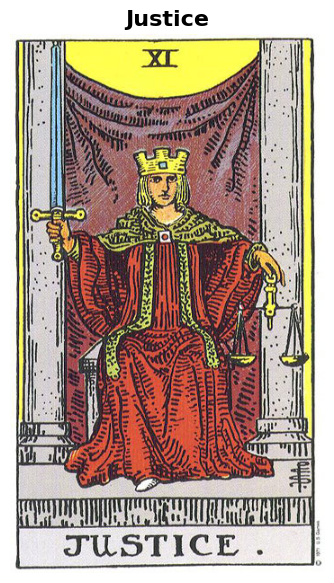


Harika bir gün geçirmenizi dilerim! 🌟


In [18]:

# NLP modeli yükle
model = SentenceTransformer('all-MiniLM-L6-v2')

# Tarot kartlarını yükle
data_dir = '/content/'  # Görsellerin olduğu klasör yolu
json_path = '/content/tarot-images.json'
df = pd.read_json(json_path, orient='records')
df_cards = pd.json_normalize(df['cards'])

# Suit açıklamaları
suit_explanations = {
    "Wands": "Ateş elementinin serisidir. Aslan, Koç, Yay burçlarını temsil eder. Bu kartlar hareketliliğe, hıza ve yaratıcılığa dair bilgileri bize sunar.",
    "Cups": "Su elementinin serisidir. Yengeç, Akrep, Balık burçlarını temsil eder. Bu kartlar duygulara, alışkanlıklara ve bilinçaltına dair bilgileri bize sunar.",
    "Swords": "Hava elementinin serisidir. İkizler, Kova, Terazi burçlarını temsil eder. Bu kartlar düşüncelere, inançlara ve zihinsel mücadelelere dair bilgileri sunar.",
    "Pentacles": "Toprak elementinin serisidir. Boğa, Başak, Oğlak burçlarını temsil eder. Bu kartlar dünya işleri, doğa ve fiziksel yapıya dair bilgileri verir.",
    "Major Arcana": "Büyük Arkana kartları yaşamın önemli temalarını ve dönüşümlerini temsil eder. Her biri farklı bir ders sunar."
}

# Kart görselini gösterme
def display_card_image(card):
    image_path = os.path.join(data_dir, card['img'])
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(5, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.title(card['name'])
        plt.show()
    else:
        print(f"{ConsoleColors.RED}Görsel bulunamadı: {image_path}{ConsoleColors.RESET}")

# Kart bilgisini gösterme ve suit açıklaması ekleme
def show_card_by_name(card_name):
    print("\nKart bilgileri getiriliyor...\U0001F52E\n")

    # Kartı adından bul
    selected_card = df_cards[df_cards['img'].str.lower() == card_name.lower()]

    if not selected_card.empty:
        card_info = selected_card.iloc[0]

        # Kart bilgilerini yazdır
        print(f"Kart İsmi: {card_info['name']}")
        print(f"Numarası: {card_info['number']}")
        print(f"Arcana: {card_info['arcana']}")
        print(f"Sembol: {card_info['suit']}")
        print(f"Kehanet: {card_info['fortune_telling']}")
        print(f"Olumlu Anlam (Light): {card_info['meanings.light']}")
        print(f"Gölge Anlam (Shadow): {card_info['meanings.shadow']}")

        # Suit açıklaması ekleme
        suit_description = suit_explanations.get(card_info['suit'], "Genel bir kategori açıklaması mevcut değil.")
        print(f"{ConsoleColors.BOLD}Suit Açıklaması:{ConsoleColors.RESET} {suit_description}")

        # Light ve Shadow anlamlarını kontrol etme
        light_meanings = card_info['meanings.light']
        shadow_meanings = card_info['meanings.shadow']
        light_count = len(light_meanings)
        shadow_count = len(shadow_meanings)

        # Light ve Shadow'a göre mesaj belirleme
        if light_count > shadow_count:
            dominance_message = f"{ConsoleColors.GREEN}Kartın genel yorumu: Olumlu 🌟{ConsoleColors.RESET}"
        elif shadow_count > light_count:
            dominance_message = f"{ConsoleColors.RED}Kartın genel yorumu: Olumsuz ⚡{ConsoleColors.RESET}"
        else:
            dominance_message = f"{ConsoleColors.BLUE}Kartın genel yorumu: Dengeli ⚖{ConsoleColors.RESET}"

        print(dominance_message)

        # Görseli yükle ve göster
        image_path = os.path.join(data_dir, card_info['img'])
        if os.path.exists(image_path):
            img = plt.imread(image_path)

            # Görseli çiz
            fig, ax = plt.subplots(figsize=(5, 7))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(card_info['name'], fontsize=16, fontweight='bold')
            plt.show()
        else:
            print(f"{ConsoleColors.RED}Görsel bulunamadı: {image_path}{ConsoleColors.RESET}")
    else:
        print(f"{ConsoleColors.RED}'{card_name}' adında bir kart bulunamadı.{ConsoleColors.RESET}")

# Ana program
def main():
    print("\nKart kodunu girin (örneğin 'p13.jpg'): ")
    card_name = input(">>> ").strip()

    if card_name.lower() in ["çıkış", "exit", "quit"]:
        print(f"\n{ConsoleColors.CYAN}Görüşmek üzere, tekrar bekleriz! 🌟{ConsoleColors.RESET}")
        return

    show_card_by_name(card_name)

    print(f"\n{ConsoleColors.ORANGE}Harika bir gün geçirmenizi dilerim! 🌟{ConsoleColors.RESET}")

# Programı başlat
if __name__ == "__main__":
    main()

In [19]:
# 3 KART ACILIMI

In [20]:
 # Bu fonksiyon, tarot kartlarını rastgele çeker, seçilen kartların falını gösterir.

def playDefault(mode): # kartları çekme ve falı okuma fonksiyonunun başlangıcı

  print('\nFalınızı okuyorum... 🔮\n')

  modes = [['Geçmiş','Şimdi','Gelecek'], ['Durum','Aksiyon','Sonuç'], ['Sen','Partnerin','İlişki']] #tarot kartı okumasında kullanabileceğimiz üç farklı kart dizilimi

  cards3 = random.sample(range(78), k=3) # rastgele 3 kart seçme

  #seçilen kartların falını, adlarını ve görsellerini depolamak için boş listelerdir.
  fortunes = []
  names = []
  images = []

  # Kartların Okunması (for döngüsü)
  # Kartların Görselleştirilmesi
  for i in range(3):
    fortunes.append( df_cards.loc[cards3[i],'fortune_telling'][random.randint(0, len(df_cards.loc[cards3[i],'fortune_telling'])-1)] )
    names.append( df_cards.loc[cards3[i],'name'] )
    images.append( df_cards.loc[cards3[i],'img'] )

  fig, ax = plt.subplots(1, 3, figsize = (8,4))

  for i in range(3):
    img = plt.imread(data_dir + '/' + images[i])
    ax[i].imshow(img)
    ax[i].set_title(names[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

#Falın Gösterilmesi
    print(f'Your \033[1m{modes[mode][i]}\033[0m is \033[1m{names[i]}.\033[0m {fortunes[i]}.')
  print()

In [21]:
def playLightDark(mode):

  print('\nFalınızı okuyorum...  🔮\n')

# Modlar ve Light-Dark Tanımlaması
  modes = [['Geçmiş','Şimdi','Gelecek'], ['Durum','Aksiyon','Sonuç'], ['Sen','Partnerin','İlişki']]
  lightDark = ['meanings.light', 'meanings.shadow']

#Kartları ve Durumu Seçme
  cards3 = random.sample(range(78), k=3)
  binary3 = [random.randint(0,1), random.randint(0,1), random.randint(0,1)]

#Kartların Bilgilerini Hazırlama
  fortunes = []
  names = []
  images = []

#Kartın Anlamını Seçme ve Görselleri Çekme
  for i in range(3):
    orientation = lightDark[binary3[i]]
    fortunes.append( df_cards.loc[cards3[i], orientation][random.randint(0, len(df_cards.loc[cards3[i], orientation])-1)] )
    names.append( df_cards.loc[cards3[i], 'name'] )
    images.append( df_cards.loc[cards3[i], 'img'] )

#Görsel Oluşturma (Matplotlib Kullanarak)
  fig, ax = plt.subplots(1, 3, figsize = (8,4))

#  Kartın Görselinin Yönlendirilmesi ve Başlıklandırılması
  for i in range(3):

    # Çekilen görsel ters ise çevir
    img = plt.imread(data_dir + '/' + images[i])
    if binary3[i] == 1:
      img = scipy.ndimage.rotate(img, 180)
    else:
      img = scipy.ndimage.rotate(img, 0)

    ax[i].imshow(img)

    # Kasrt ters çevrilmişse reversed yaz
    name = names[i]
    if binary3[i] == 1:
      name += ' (Reversed)'

    ax[i].set_title(names[i])

    ax[i].set_xticks([])
    ax[i].set_yticks([])

#Fal Mesajı Yazdırma
    print(f'Your \033[1m{modes[mode][i]}\033[0m is \033[1m{name}.\033[0m {fortunes[i]}.')
  print()

In [22]:
# Kullanıcı girişi

def validInt(min, max):
  while True:
    try:
      ans = int(input('Bir sayı giriniz: '))

      if ans < min:
        raise Exception
      elif ans > max:
        raise Exception
      else:
        return ans

    except:
      return 0

Nasıl bır fal bakmak istersiniz? 
[1] 3- Klasik Fal 
[2] 3 Light & Shadow Falı 
[*] Çıkış
Bir sayı giriniz: 1

[1] Geçmiş-Şimdi-Gelecek 
[2] Durum-Aksiyon-Sonuç 
[3] Sen-Partnerin-İlişki 
[*] Exit
Bir sayı giriniz: 2

Falınızı okuyorum... 🔮

Your Durum is Four of Pentacles. A rainy day is coming—it's time to save.
Your Aksiyon is The High Priestess. A mysterious woman arrives.
Your Sonuç is Nine of Cups. Whatever you want, you'll get it.



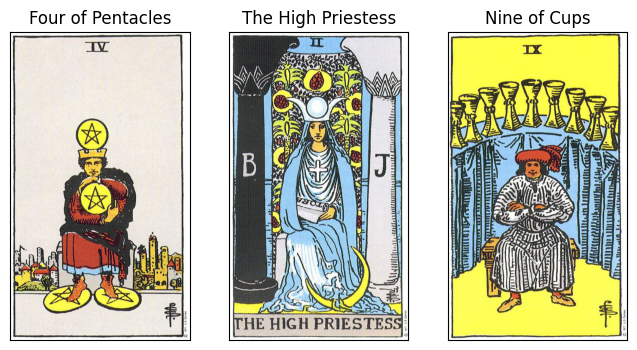

In [23]:
# Kullanıcıdan Ana Seçim Yapmasını İsteme

print('Nasıl bır fal bakmak istersiniz? \n[1] 3- Klasik Fal \n[2] 3 Light & Shadow Falı \n[*] Çıkış')

r = validInt(1,2)
if r == 1:
  print('\n[1] Geçmiş-Şimdi-Gelecek \n[2] Durum-Aksiyon-Sonuç \n[3] Sen-Partnerin-İlişki \n[*] Exit')

  r = validInt(1,3)
  if r != 0:
    playDefault(r-1)
  else:
    print('\nFalınızı okuyorum... 🔮')

elif r == 2:
  print('\n[1] Geçmiş-Şimdi-Gelecek \n[2] Durum-Aksiyon-Sonuç \n[3] Sen-Partnerin-İlişki \n[*] Exit')

  r = validInt(1,3)
  if r != 0:
    playLightDark(r-1)
  else:
    print('\nCFalınızı okuyorum... 🔮')

else:
  print('\nFalınızı okuyorum... 🔮')


  r = validInt(1,3)
  if r != 0:
    playDefault(r-1)
  else:
    print('\nFalınızı okuyorum... 🔮')